<h1><center>Spatial Cross-Validation</center></h1>
<h3><center>Reid Falconer</center></h3>

In [4]:
# Install Libraries 
library(ModelMetrics)
library(sperrorest)
library(mvnfast)
library(tictoc)
library(knitr)
library(kableExtra)
library(IRdisplay)
library(raster)
library(tmap)
library(sf)
library(tidyverse)

Cross validation (CV) methods work well for most model-assessment and model-selection problems. However, on spatial data, they break down because it depends on assumptions that are often violated within the spatial context. In this notebook, I elaborate on these issues before surveying modified CV methods for spatial data.

Spatial data exhibit a few properties that make it difficult to apply standard statistical methods to them. For one, spatial data exhibits spatial autocorrelation, where observations close to each other in space have related values. [Figure 1](#figure_1) shows this phenomenon in a small of a landslide locations dataset collected by <cite data-cite="4834982/BBIFZRJB"></cite>. Note how the landslides cluster together, so any attributes related to landslides, e.g., slope, soil type, terrain, etc., will also show similar spatial clustering patterns.

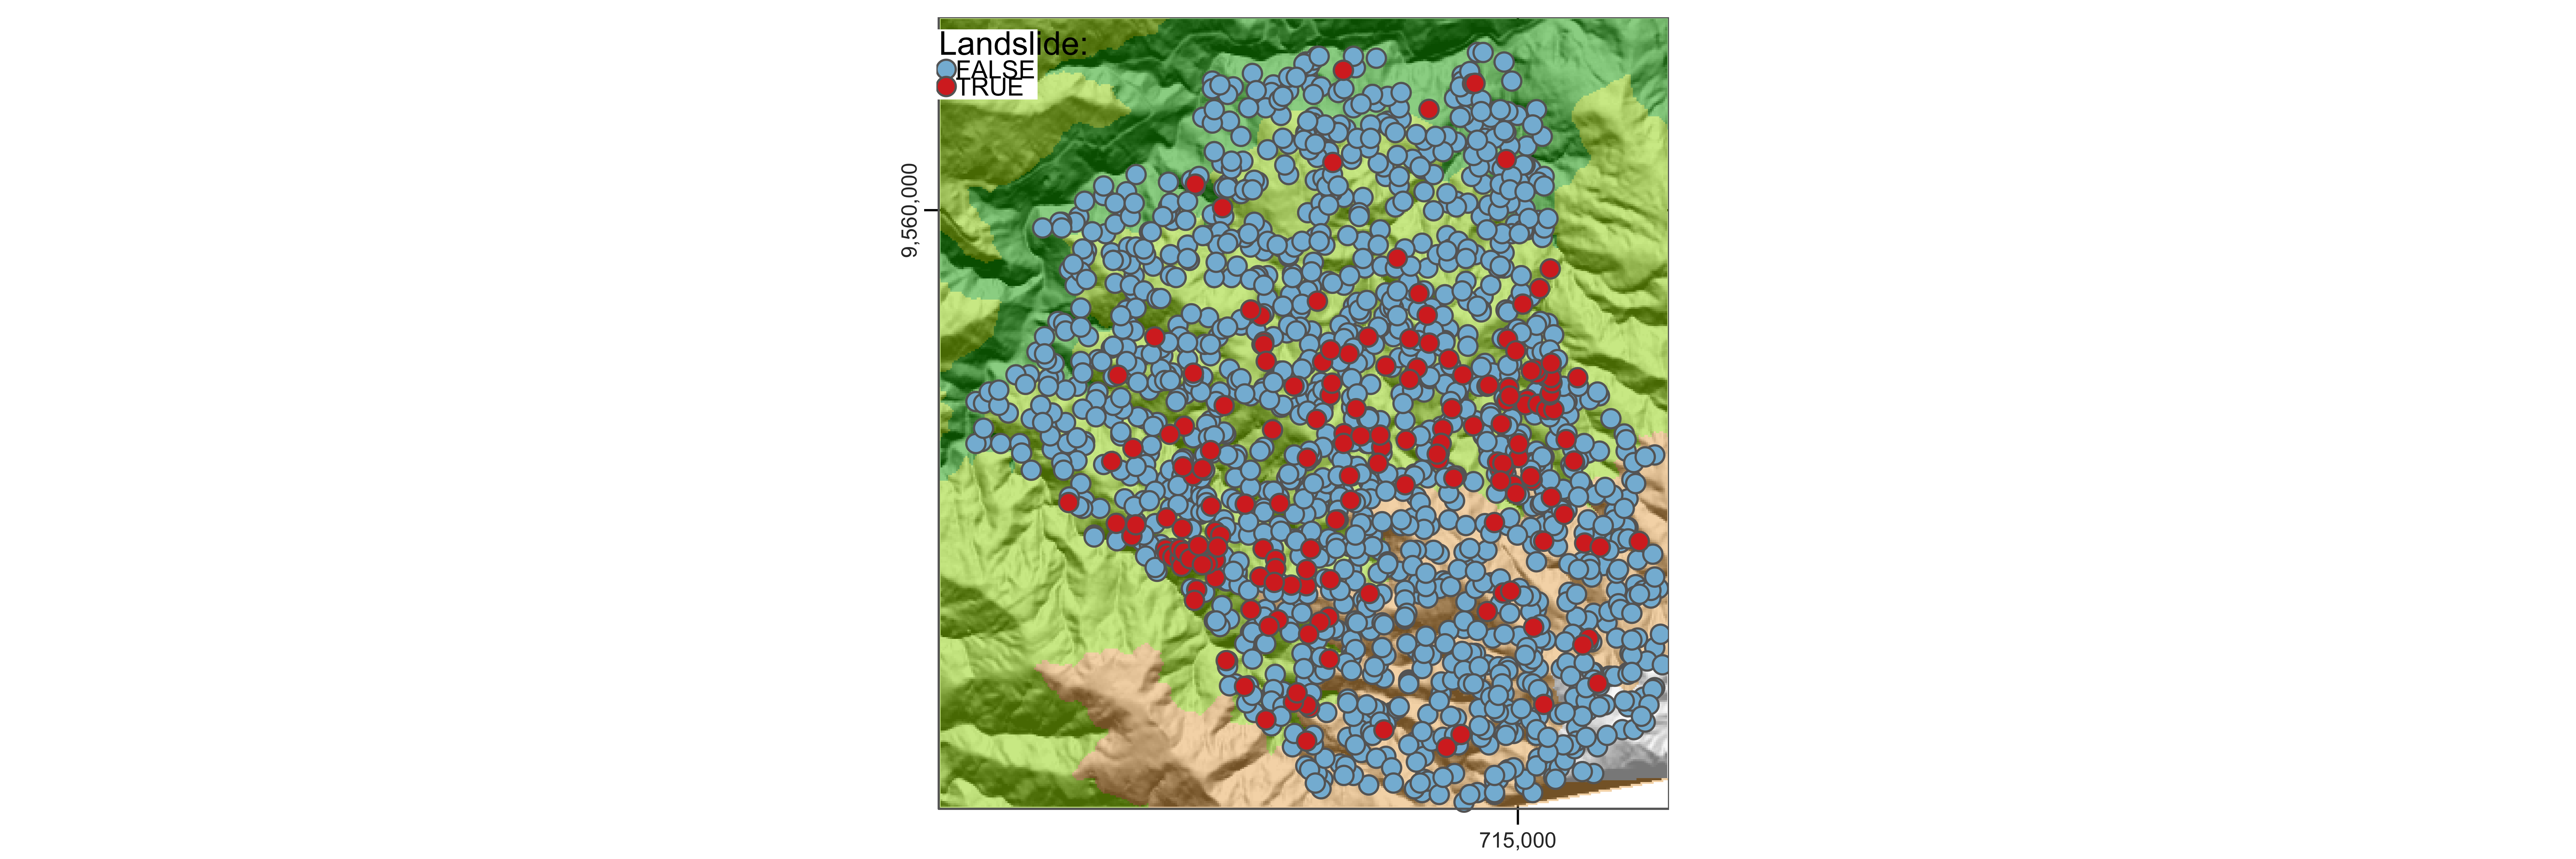

In [5]:
# Code for Figure 1
{options(repr.plot.width=12, repr.plot.height=4, repr.plot.res = 600)
data("landslides", package = "RSAGA")
data("ta", package = "spDataLarge")

# select non-landslide points
non_pts = filter(landslides, lslpts == FALSE)
# select landslide points
lsl_pts = filter(landslides, lslpts == TRUE)
# create smaller landslide dataset (lsl)
lsl = bind_rows(non_pts, lsl_pts)

lsl_sf = st_as_sf(lsl, coords = c("x", "y"), crs = 32717)
hs = hillShade(ta$slope * pi / 180, terrain(ta$elev, opt = "aspect"))
rect = tmaptools::bb_poly(hs)
bbx = tmaptools::bb(hs, xlim = c(-0.02, 1), ylim = c(-0.02, 1), relative = TRUE)
tm_shape(hs, bbox = bbx) +
    tm_grid(col = "black", n.x = 1, n.y = 1, labels.inside.frame = FALSE,
            labels.rot = c(0, 90)) +
    tm_raster(palette = gray(0:100 / 100), n = 100, legend.show = FALSE) +
    tm_shape(ta$elev) +
    tm_raster(alpha = 0.5, palette = terrain.colors(10), legend.show = FALSE) +
    tm_shape(lsl_sf) + 
    tm_bubbles("lslpts", size = 0.2, palette = "-RdYlBu", title.col = "Landslide: ") +
  qtm(rect, fill = NULL) +
    tm_layout(outer.margins = c(0.04, 0.04, 0.02, 0.02), frame = FALSE) +
  tm_legend(bg.color = "white")
 }

Spatial autocorrelation often leads to difficulties with statistical methods (e.g., see XXX, XXX]) because many methods assume that observations are independent and identically distributed (i.i.d.). Spatial autocorrelation, however, means that drawing one observation implies that nearby observations will likely be similar to it, thus making it unreasonable to assume that points are i.i.d. As such, many methods, including modeling and model assessment methods, perform worse when naively applied to spatial data.

Interestingly, CV does not necessarily assume that observations are i.i.d. Instead, it depends on a modified assumption of independence based on sampling and resampling. When scientists gather data, they collect a random sample from the population. CV simulates sampling by resampling; rather than sampling from the whole population, CV resamples from the given dataset.

CV assumes that the original sample is representative of the population and that its resamples are collected in the same way that a new sample from the population would be collected. If observations are i.i.d., then this assumption is trivially satisfied. Without an i.i.d. assumption, though, the assumption still holds for spatial data so long as the resampled training and validation sets are collected in the same manner as the original sample was: collected in spatial groups.
<div class="cite2c-biblio"></div>
However, K-fold CV does not resample spatial groups of data. Instead, it uses random resampling, which produces training and validation sets whose points are distinct but come from overlapping spatial regions. To illustrate this point, [Figure 2](#figure_2) gives an example of how one fold of 5-fold CV might partition points into a training set (white points) and a validation set (black points).

<a id='figure_2'></a>
<div style="width:image width px; font-size:100%; text-align:center;"><img src="../images/5foldcv.png" alt="alternate text" width="250" height="250" style="padding-bottom:0.5em;" />Figure 1: Example of 5-fold CV fold</div> 

Having training-set points interspersed among validation-set points leads to three main challenges for model assessment. **First**, the presumed independence between the training set and the validation set is broken. Consider the validation-set point $a$ in [Figure 2](#figure_2). As indicated by the dotted circle, $a$ is very close to two other points in its corresponding training set. Due to spatial autocorrelation, knowing information about the two nearby training-set observations gives information about $a$. To clarify, suppose that $a$ has a response $y_a$ of the form $y_a = f(\textbf{x}_i) + \epsilon_a $. The training-set points near a would not only tend to have $\textbf{x}_i$ similar to $\textbf{x}_a$, but also tend to have $\epsilon_i$ similar to $\epsilon_a$. Thus, if a model overfits the training set, it would perform exceptionally well on $a$, which would undermine the rationale for using a validation set.

The **second** challenge is that the spatial autocorrelation structures in the training set are not preserved. The training set in [Figure 2](#figure_2) contains observations that are more spread out in space, on average, than the original training set. As such, the observations do not exhibit the same degree of spatial autocorrelation as the original training set, which can affect model training.

The **third** and final challenge relates to interpolation and extrapolation. Researchers usually want to assess model extrapolation: how well models can predict observations in spatial regions other than those of the original samples. Such observations will often have different latent-variable values. Interspersing training-set points among validation-set points, however, leads to similarities between the latent-variable values of the training and validation sets, since they are drawn from overlapping spatial regions. Thus, K-fold CV would be better at assessing model interpolation: how well the models can predict observations in the same spatial region as the training set and not model extrapolation.

## Methods to Account for Spatial Autocorrelation

There are many ways to modify CV to account for the challenges described above. For spatial data, the resampling in CV needs to mirror the original sampling, so resampled points should be spatially grouped. [Figure 3](#figure_3) below shows an example. On the left, the solid black circles are points that have been randomly sampled (top-left) and resampled (bottom-left). On the right, points are sampled and resampled in spatial clusters. Note that while the sampled/resampled points on the left are uniformly spread across the rectangle, the sampled/resampled points on the right are closer together, which preserves the spatial relationships in the data. Grouping observations together in specific ways for CV is known as blocking <cite data-cite="4834982/JFZE4RAZ"></cite>. Intuitively, blocking changes the units of resampling from individual observations to user-defined blocks of observations. There are many blocking methods, but this notebook will focus on spatial blocking, where blocks are groups of observations that are close to each other in space (x,y coordinates). Another modification of CV for spatial data involves the use of buffer regions, which are simply points spatially located between the defined training and validation sets that are used in neither set. Using buffer regions accomplishes two goals. First, it reduces the dependencies between points near the edges of training and validation sets <cite data-cite="4834982/PEWU8PXH"></cite>. Second, it adds distance between training and validation sets, which increases the amount of extrapolation in a model’s predictions on a validation set <cite data-cite="4834982/JFZE4RAZ"></cite>.

<a id='figure_3'></a>
<div style="width:image width px; font-size:100%; text-align:center;"><img src="../images/spatialcv.png" alt="alternate text" width="500" height="400" style="padding-bottom:0.5em;" />Figure 3: Random sampling/resampling vs. spatially grouped sampling/resampling</div> 

## Simulations

### Model Assessment Simulation

The simulations aim to show that for spatially structured data, spatial resampling methods indeed outperform non-spatial methods. The simulation procedure begins as follows. First, we generate 100 datasets, each containing 500 points placed uniformly at random in a $100 \times 100$ grid. For each point, we randomly generate spatially correlated variables $x_1$, $x_2$, and $x_3$ and spatially correlated noise $\epsilon_{spatial}$ . Finally, we generate the response value as $f(x_1; x_2; x_3) + \epsilon_{spatial} + \epsilon$, where $\epsilon$ is non-spatial random noise. For each dataset $T$, the true conditional error $Err_T$ of the given model is computed by fitting the model to $T$ and computing its average root-mean-square error over all 99 other datasets. Intuitively, we treat the other 99 datasets as a large draw from the same population as $T$ , so performance on that large sample should be a good estimate of performance on the overall population. Expected $Err$ is computed by taking the average of all 100 $Err_T$ values.

The model assessment simulation compares the true errors of linear models to the error estimates produced by training error, 16-fold CV error, LOOCV error, 4x4 buffered grid CV error, and SLOO CV error (with buffer size 15). The data-generating function used is

$$
f ( x_1 , x_2 , x_3 ) = 2 \sin ( \pi x_1 ) + x_1 + 2 x_2 + 4 * 1_{x_3 > 0} ( x_3 )
$$

where $1_{x_3>0}(x_3)$ is the indicator function that is $1$ if $x_3 > 0$ and $0$ otherwise. This is done in an attempt to make make the signal roughly linear, but complex enough that the learning curve for a linear model will not achieve a minimum with too few training observations (which would eliminate the pessimistic bias that K-fold CV suffers for low values of K.

For each simulated dataset, we compute the aforementioned five estimates of the out-ofsample error of the linear model $m: y \sim x_1 + x_2 + x_3$. Table XX shows the average values of the five error estimates over the 100 simulated datasets, along with the average true error Err. Training error is the most optimistic assessment method, as expected. Also, we generally notice that the nonspatial CV methods are more optimistic than the spatial CV methods.

### Model Selection Simulation

Here the the data-generating function is:


$$
f (x_1 , x_2) = 2 \sin ( \pi x_1 ) + 2 x_2
$$

For each dataset we compute the seven error estimates for four models:
1. $M_1: y \sim x_1$ (underspecified model 1)
2. $M_2: y \sim x_2$ (underspecified model 2)
3. $M_3: y \sim x_1 + x_2$ (true model)
4. $M_4: y \sim x_1 + x_2 + x_3$ (overspecified model)

Each model-assessment method ''selects'' the model $M_i$ that it estimates to have the least error. The table below shows the number of times each model was selected by each model assessment method. Ideally, we want our selection methods to choose the true model $m_3$, in bold. Importantly, however, we find that the spatial methods significantly outperform their non-spatial counterparts on the spatial data. 

LOOCV and SLOO CV appear to have the best performance for nonspatial and spatial methods, respectively.

Overall, the selection simulations show that the spatial CV methods discussed in this analysis are better at model selection than the non-spatial CV methods. 

In [7]:
# CROSS VALIDATION PROCEDURES 

# INPUTS:
# - data frame
# - number of folds
# - (model formula)
# - (model parameters)

# OUTPUT:
# - CV error estimate (RMSE)

# Non-Spatial CV procedures
# K-fold CV for lm
cv_lm <- function(df, nfolds, model_formula) {
  cv_errors <- vector(mode = "numeric", length = nfolds)
  
  # Shuffle data and partition folds
  temp <- df[sample(nrow(df)),]
  folds <- cut(seq(1,nrow(temp)),
               breaks = nfolds,
               labels = FALSE)
  for(i in 1:nfolds){
    # Split training/testing sets
    test_index <- which(folds==i, arr.ind = TRUE)
    test <- temp[test_index, ]
    train <- temp[-test_index, ]
    # Fit lm
    fitted_model <- lm(model_formula, data = train)
    # Store error
    diffs <- predict(fitted_model, test) - test$val
    cv_errors[i] <- mean(diffs^2)
  }
  return(sqrt(mean(cv_errors)))
}

# Spatial Cross Validation procedures 
# Buffered grid cross validation
cv_grid_buffer_lm <- function(df, nrow, ncol, model_formula) {
  # Use sperrorest to partition data into spatial folds
  nfolds_spat <- nrow*ncol
  partition <- partition_tiles(
    as.data.frame(df),   # See testing_sperrorest_package.Rmd
    nsplit = c(ncol,nrow),   # nrow x ncol grid
    reassign = FALSE)   # Don't reassign observations in small folds
  
  # Hacky method to number which fold each observation is in
  all_folds <- partition$`1`
  count = 1
  fold_df <- df %>%
    select(x, y)
  for (fold in all_folds){
    varname <- paste("fold", count, sep = "")
    fold_df <- fold_df %>%
      mutate(!!varname := count*(row_number() %in% fold$test))
    count <- count + 1
  }
  folds <- rowSums(fold_df[,c(3:ncol(fold_df))])
  df_spatial <- df %>%
    mutate(fold = folds)
  
  # Find fold neighbors of each fold (again, hacky)
  fold_neighbors <- vector(mode = "list", length = nfolds_spat)
  for (i in 1:nfolds_spat) {
    list1 <- c(i, i-nrow, i+nrow)
    list2 <- switch(as.character(i %% nrow),
                    "0" = c(i-1, i-1-nrow, i-1+nrow),
                    "1" = c(i+1, i+1-nrow, i+1+nrow),
                    c(i-1, i-1-nrow, i-1+nrow, i+1, i+1-nrow, i+1+nrow))
    fold_neighbors[[i]] <- c(list1, list2)
  }
  
  # Compute buffered grid CV error
  results_list <- vector(mode="numeric", length = nfolds_spat)
  num_empty_folds <- 0
  for (j in 1:nfolds_spat) {
    train <- df_spatial %>% filter(!(fold %in% fold_neighbors[[j]]))
    test <- df_spatial %>% filter(fold == j)
    if (dim(test)[1] == 0) {   # If test set is empty
      num_empty_folds <- num_empty_folds + 1
      next
    }
    # Train model & make predictions
    model_lm <- lm(model_formula, data = train)
    model_preds <- predict(model_lm, test)
    # Store results
    results_list[[j]] <- rmse(model_preds, test$val)
  }
  return(sum(unlist(results_list)) / (nfolds_spat - num_empty_folds))
}
# Spatial leave one out cross validation (SLOO CV)
cv_SLOO_lm <- function(df, buffer, model_formula) {
  model <- sperrorest(
    model_formula,
    data=df,
    coords=c("x", "y"),   # variables that contain x/y coordinates
    model_fun = glm,
    pred_fun = predict,
    smp_fun = partition_loo,   # SLOO
    smp_args = list(repetition = 1,
                    buffer = buffer,
                    seed1 = 123),   # 1 repetition
    progress=FALSE)
  return(summary(model$error_rep)["test_rmse",]$mean)
}

In [8]:
# Build function to randomly generate spatially correlated data

# INPUT: 
#  - true function f:(X1 + X2 + X3) -> val
#  - whether variables & noise are independent or spatially correlated
#  - (maximum x-coordinate)
#  - (maximum y-coordinate)
#  - (number of points)
#  - (SD of noise)

# OUTPUT: df with `npoints` points, each with:
#  - x/y coordinates
#  - X1,X2 and X3 values, where Xi's are spatially correlated
#  - Y values from f(X1 + X2 + X3) + e + e_spatial

# Two kinds of noise are added:
#  1) Independent normal noise N(0, sigma)
#  2) Spatially autocorrelated noise

generate_sample <- function(f, spat_vars, spat_noise, max_x=100, max_y=100, npoints=500, sigma=0.5, decay=10) {
  # Generate x/y coordinates, uniformly across space
  x <- runif(npoints, 0, max_x)
  y <- runif(npoints, 0, max_y)
  df <- data.frame(x,y)
  
  if(spat_vars){
    # Spatially dependent covariance matrix
    mat <- as.matrix(proxy::dist(df))    # distance matrix
    sigma_mat <- 1 - mat/(mat+decay)   # decaying function to simulate distance decay
    sigma_mat <- (sigma^2)*sigma_mat     # diagonals equal variance
  } else{
    # Independent covariance matrix
    sigma_mat <- diag(npoints)
  }
  
  vars <- rmvn(
    n=3,   # number of variables to generate (without noise)
    mu=rep(0, npoints),   # vector of variable means
    sigma = sigma_mat, 
    ncores = 4)
  
  if(spat_noise){
    if(!spat_vars){
      # Generate sp. dep. cov. matrix if haven't done so yet
      mat <- as.matrix(proxy::dist(df))   # distance matrix
      sigma_mat <- 1 - mat/(mat+1)        # decaying function to simulate distance decay
      sigma_mat <- (sigma^2)*sigma_mat    # diagonals equal variance
    }
    # Spatially dependent noise 
    noise <- as.vector(rmvn(
      n=1,
      mu=rep(0, npoints),
      sigma = sigma_mat, 
      ncores = 4))
  } else{
    # Spatially independent noise
    noise <- rnorm(npoints, 0, sigma)
  }
  
  # Add another layer of nonspatial noise
   extra_noise <- rnorm(npoints, 0, sigma)
   noise <- noise + extra_noise
  
  df <- cbind(df, t(vars), noise)
  colnames(df) <- c("x","y","X1","X2","X3","eps")
  df <- df %>%
    mutate(val = f(X1,X2,X3) + eps)
  return(df)
}

In [9]:
# SIMULATIONS
# Define parameters for simulation 
{SEED <- 100
set.seed(SEED)
MAX_X <- 100   # Boundaries of data to use
MAX_Y <- 100
NUMSAMP <- 100   # Number of simulation samples to generate
NPOINTS <- 500   # Number of points per sample
NFOLDS <- 16   # Number of folds for K-fold cv
NROW <- 4   # Number of rows for grid CV
NCOL <- 4   # Number of columns for grid CV
BUFFER <- 15   # Buffer for SLOO CV
 }

In [23]:
# Simulation study of different methods for estimating errors

# METHODS:
# Data: simulated data
#  - 500 observations on 100x100 grid
#  - Spatially correlated variables X1, X2, X3
#  - Spatially correlated noise
# True model: function of  X1, X2, X3
# Fit model: linear regression
# CV strategies:
#  1) Training error
#  2) K-fold CV
#  3) LOO CV
#  4) Buffered Grid CV
#  5) Spatial LOO CV
# Error metric: RMSE

for (tuple in list(c(F,F), c(T,T))) {
  tic()
  
  SP_VARS <- tuple[1]   # Whether vars are spat. correlated
  SP_NOISE <- tuple[2]   # Whether noise is spat. correlated

  # Define true model
  f <- function(a,b,c){
    # original function
    return(2*sin(pi*a)+a+2*b+4*(c>0))
  }
  
  model_formula <- as.formula("val ~ X1 + X2 + X3")
  
  # Generate random samples
  all_samps <- vector(mode = "list", length = NUMSAMP)
  all_samps <- lapply(all_samps, function(x) {
    generate_sample(f, spat_vars = SP_VARS, spat_noise = SP_NOISE, npoints = NPOINTS)})
  
  # Compute true error and error estimates (1-5) for each sample
  err_df <- data.frame()
  for (i in 1:NUMSAMP) {
    # Get sample i to use for training
    df_sim_i <- all_samps[[i]]
    
    # Fit lm to df_train
    model_lm <- lm(model_formula, data = df_sim_i)
    
    # Compute test errors on all other training sets
    get_err <- function(df) {
      rmse(df$val, predict(model_lm, df))
    }
    errs_test <- unlist(lapply(all_samps, get_err))
    # Compute true error (need to remove error for df_sim_i)
    err_true <- (sum(errs_test)-errs_test[i]) / (NUMSAMP-1)
    
    # Compute training error (1)
    err_train <- rmse(predict(model_lm, df_sim_i), df_sim_i$val)
    
    # Compute K-fold CV error (2)
    err_cv <- cv_lm(df_sim_i, NFOLDS, model_formula = model_formula)
    
    # Compute LOO CV error (3)
    err_loo <- cv_lm(df_sim_i, NPOINTS, model_formula = model_formula)
    
    # Compute buffered grid CV error (4)
    err_grid <- cv_grid_buffer_lm(df_sim_i, NROW, NCOL, model_formula = model_formula)
    
    # Compute SLOO CV error (5)
    err_sloo <- cv_SLOO_lm(df_sim_i, BUFFER, model_formula = model_formula)
    
    # Output results
    err_df <- rbind(err_df, c(i, err_true, err_train, err_cv, err_loo, err_grid, err_sloo))
  }
  colnames(err_df) <- c("set_number", "err_true", "err_train", "err_cv",
                        "err_loo", "err_grid_buffer", "err_sloo")
  
  # Write output
  output_rmse <- err_df
    
  # run time  
  toc(func.toc = toc.outmsg)
}

In [10]:
# save the output_rmse for future use
#saveRDS(output_rmse,"../data/output_rmse.RDS")

# read in output_rmse 
output_rmse <- readRDS("../data/output_rmse.RDS")

In [11]:
# Code for Table 1
{output_rmse %>%
    rename(`Training Error` = err_train,
         `16-Fold CV` = err_cv,
         `LOOCV` = err_loo,
         `4 x 4 Buffered Grid CV` = err_grid_buffer,
         `SLOO CV` = err_sloo,
         `True Error` = err_true) %>%
    gather(
        key=Method, value=estimate, 
        `True Error`:`SLOO CV`) %>%
    group_by(Method) %>%
    summarize("Average Estimate" = mean(estimate)) %>%
    arrange(factor(`Average Estimate`)) %>%   # reorder rows
    kable("html") %>%
    column_spec(c(1), bold = T) %>%
    kable_styling("hover", full_width = T) %>%
    row_spec(0, bold = T, color = "black", background = "lightgrey")  %>%
    as.character() %>%
    IRdisplay::display_html()
 }

Method 
 Average Estimate 
 
 
 
 
 Training Error 
 1.668687 
 
 
 LOOCV 
 1.684474 
 
 
 16-Fold CV 
 1.685044 
 
 
 SLOO CV 
 1.731775 
 
 
 4 x 4 Buffered Grid CV 
 1.765110 
 
 
 True Error 
 1.848265

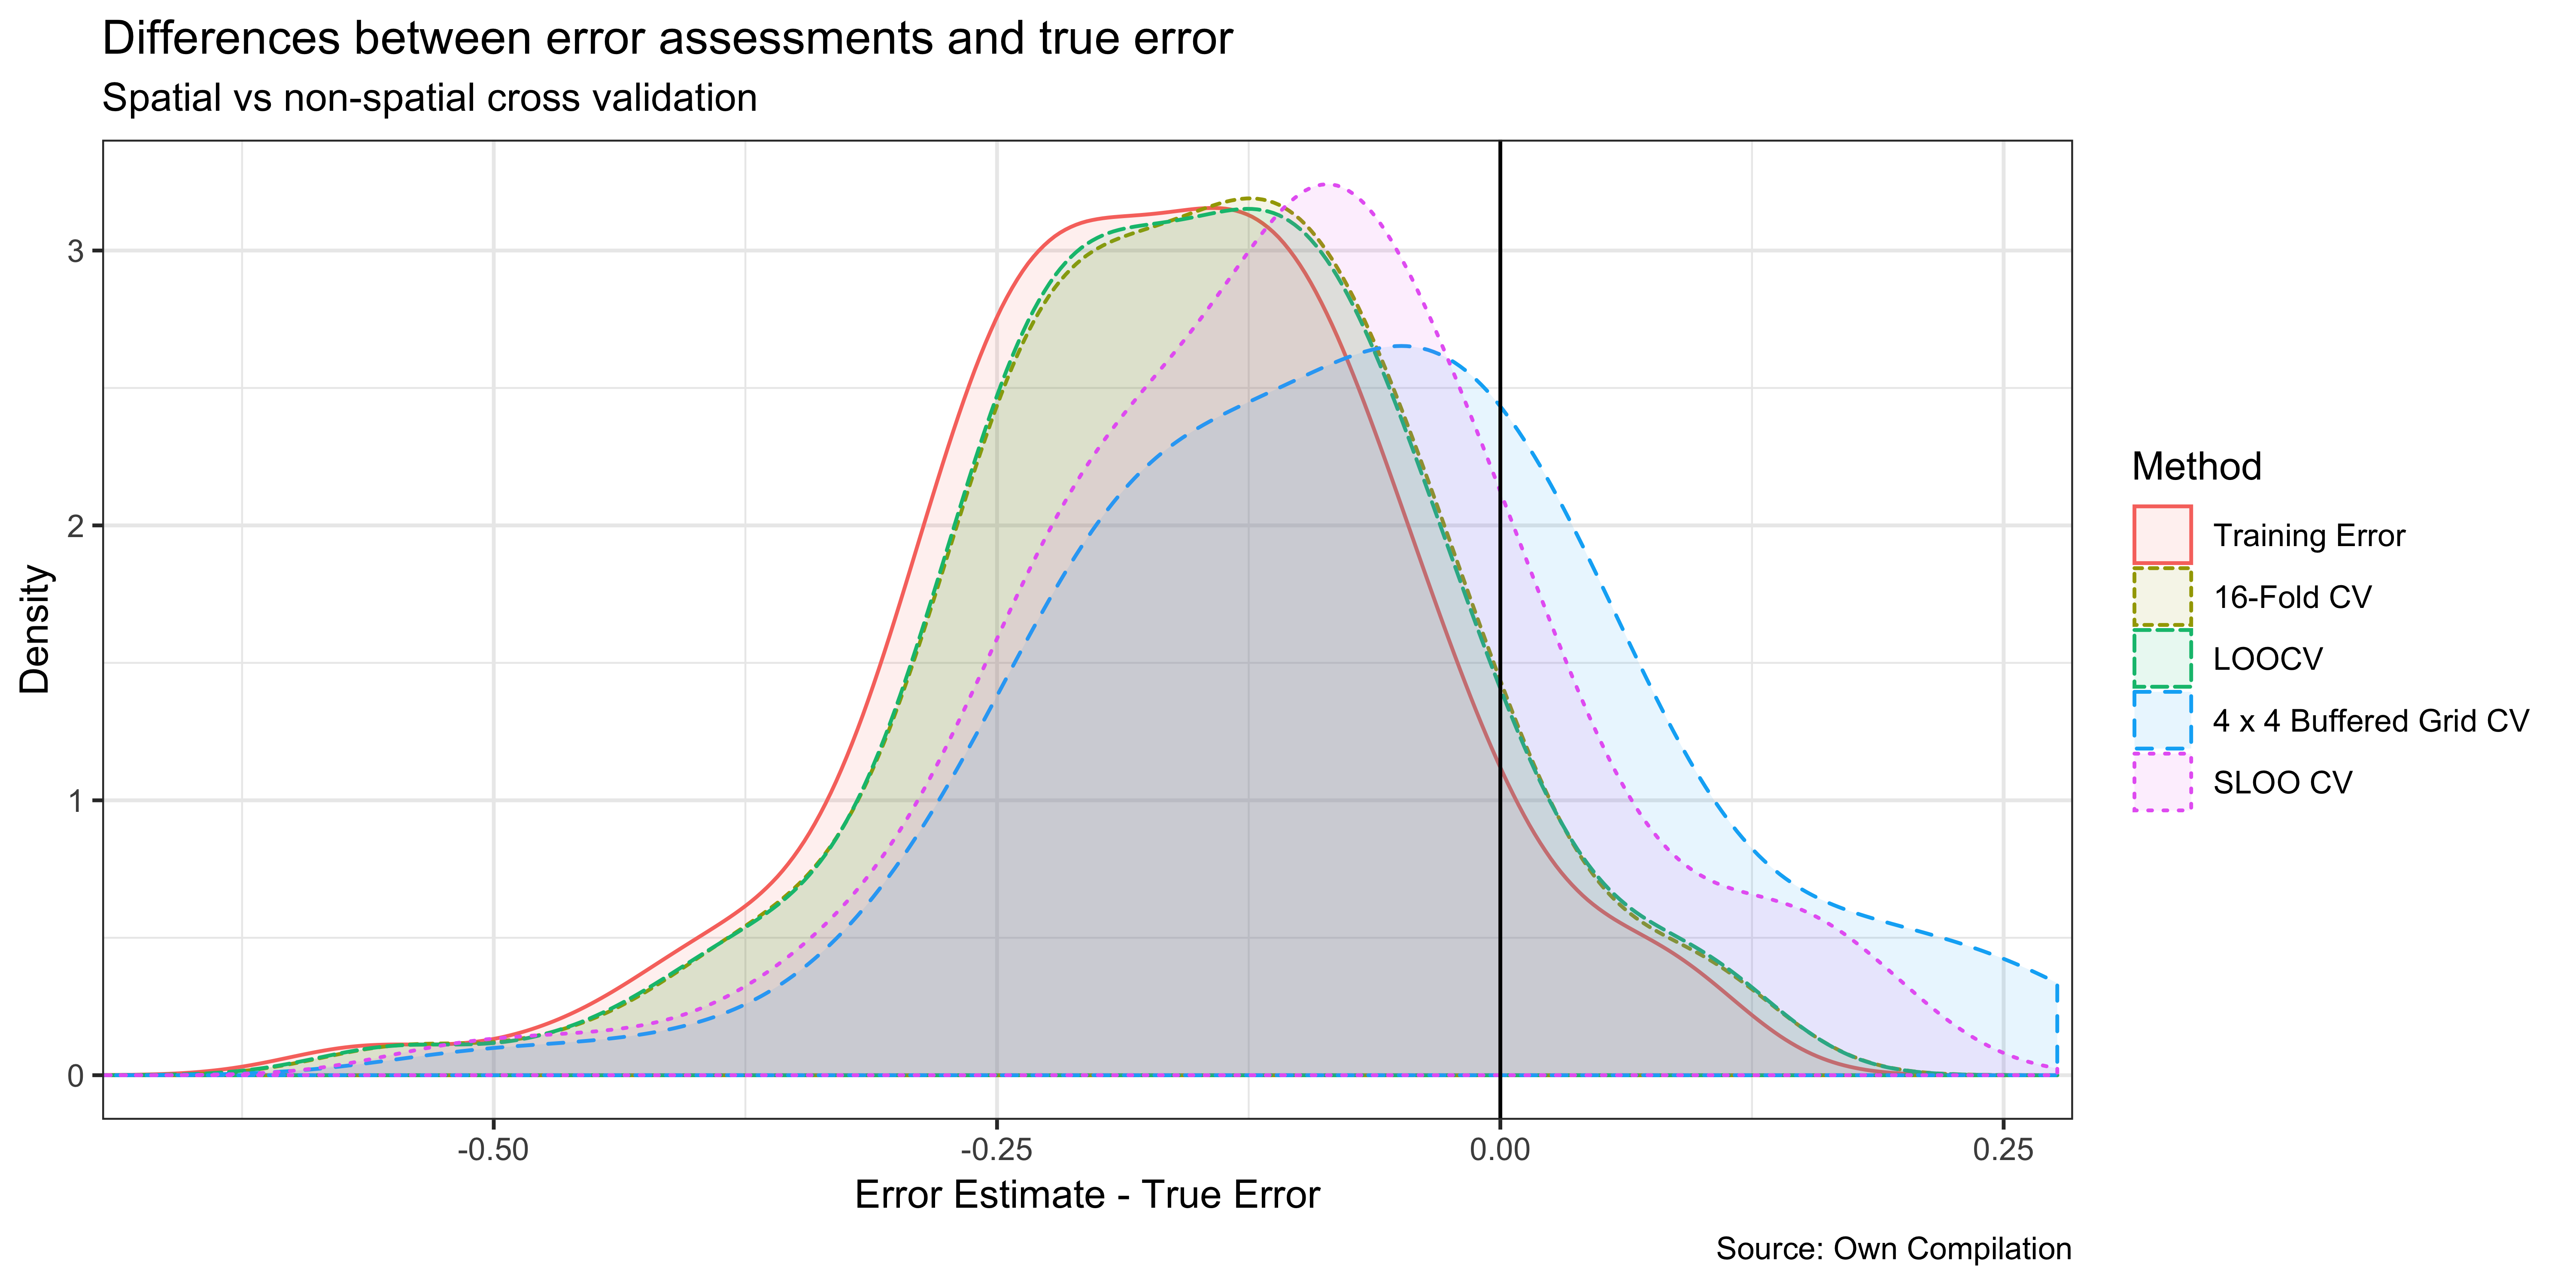

In [12]:
# Code for Figure 4
{options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 600)
output_rmse %>%
    rename(`Training Error` = err_train,
         `16-Fold CV` = err_cv,
         `LOOCV` = err_loo,
         `4 x 4 Buffered Grid CV` = err_grid_buffer,
         `SLOO CV` = err_sloo) %>%
    gather(
        key = Method, value = estimate, 
        `Training Error`:`SLOO CV`) %>%
  mutate(Method = factor(Method, levels = c("Training Error", "16-Fold CV", "LOOCV", 
                                            "4 x 4 Buffered Grid CV", "SLOO CV"))) %>%
  ggplot((aes(x = estimate-err_true))) +
  geom_density(aes(color = Method, fill = Method, linetype = Method), alpha = 0.1) +
  scale_fill_discrete(name='Method',labels=c("Training Error", "16-Fold CV", "LOOCV", 
                                             "4 x 4 Buffered Grid CV", "SLOO CV")) +
  scale_color_discrete(name='Method',labels=c("Training Error", "16-Fold CV", "LOOCV", 
                                              "4 x 4 Buffered Grid CV", "SLOO CV")) +
  geom_vline(xintercept=0) +
  coord_cartesian(xlim=c(-0.65, 0.24)) +
  labs(
    y="Density",
    x="Error Estimate - True Error",
    title="Differences between error assessments and true error",
    caption="Source: Own Compilation",
    subtitle = "Spatial vs non-spatial cross validation"
  ) + theme_bw()
 }

In [ ]:
# Simulation study of different methods for model selection

# METHODS:
# Data: simulated data
#  - 500 observations on 100x100 grid
#  - Spatially correlated variables X1, X2
#  - Spatially correlated noise
# True model: function of X1, X2
# Fit model: linear regression
# CV strategies:
#  1) Training error
#  2) K-fold CV
#  3) LOO CV
#  4) Buffered Grid CV
#  5) Spatial LOO CV
# Error metric: RMSE

  for (tuple in list(c(F,F), c(T,T))) {
    tic()
    
    SP_VARS <- tuple[1]   # Whether vars are spat. correlated
    SP_NOISE <- tuple[2]   # Whether noise is spat. correlated
    # SP_VARS <- TRUE   # Whether vars are spat. correlated
    # SP_NOISE <- TRUE   # Whether noise is spat. correlated
    
    # Define true model
    f <- function(a,b,c){
      # original function
      return(2*sin(pi*a)+2*b)
    }
    
    # Generate random samples
    all_samps <- vector(mode = "list", length = NUMSAMP)
    all_samps <- lapply(all_samps, function(x) {
      generate_sample(f, spat_vars=SP_VARS, spat_noise=SP_NOISE, npoints=NPOINTS)})
    
    # Compute true error and error estimates (1-7) for each sample, model
    # --> Select model with least error
    sel_df <- data.frame()
    for (i in 1:NUMSAMP) {
      # Get sample i
      df_sim_i <- all_samps[[i]]
      model_formulas <- list(
        as.formula("val ~ X1"),
        as.formula("val ~ X2"),
        as.formula("val ~ X1 + X2"),
        as.formula("val ~ X1 + X2 + X3"))
      
      # Compute training error (1) for each model
      get_err_train <- function(formula) {
        model_lm <- lm(formula, data=df_sim_i)
        return(rmse(predict(model_lm, df_sim_i), df_sim_i$val))
      }
      errs_train <- lapply(model_formulas, get_err_train)
      # Select model with least training error
      sel_train <- which.min(errs_train)
      
      # Compute K-fold CV error (1) for each model
      get_err_cv <- function(formula) {
        return(cv_lm(df_sim_i, NFOLDS, model_formula=formula))
      }
      errs_cv <- lapply(model_formulas, get_err_cv)
      # Select model with least K-fold CV error
      sel_cv <- which.min(errs_cv)
      
      # Compute LOO CV error (2) for each model
      get_err_loo <- function(formula) {
        return(cv_lm(df_sim_i, NPOINTS, model_formula=formula))
      }
      errs_loo <- lapply(model_formulas, get_err_loo)
      # Select model with least K-fold CV error
      sel_loo <- which.min(errs_loo)
      
      # Compute buffered grid CV error (3) for each model
      get_err_grid <- function(formula) {
        return(cv_grid_buffer_lm(df_sim_i, NROW, NCOL, model_formula=formula))
      }
      errs_grid <- lapply(model_formulas, get_err_grid)
      # Select model with least buffered grid CV error
      sel_grid <- which.min(errs_grid)
      
      # Compute SLOO CV error (4) for each model
      get_err_sloo <- function(formula) {
        return(cv_SLOO_lm(df_sim_i, BUFFER, model_formula=formula))
      }
      errs_sloo <- lapply(model_formulas, get_err_sloo)
      # Select model with least buffered grid CV error
      sel_sloo <- which.min(errs_sloo)
      
      # Output results of both selection and assessment
      sel_df <- rbind(sel_df, c(i, sel_train, sel_cv, sel_loo, sel_grid, sel_sloo))
    }
    colnames(sel_df) <- c("set_number", "sel_train", "sel_cv", "sel_loo", 
                          "sel_grid", "sel_sloo")
    
    # Output results from model selection
    output_selection <- sel_df
    
    toc()
  }

In [14]:
# save the output_selection for future use
#saveRDS(output_selection,"../data/output_selection.RDS")

# read in output_selection 
output_selection <- readRDS("../data/output_selection.RDS")

In [15]:
# Code for Table 2
{order_vec <- c("Training Error", "16-Fold CV", "LOOCV", "4 x 4 Buffered Grid CV", "SLOO CV")
output_selection %>%
    rename(`Training Error` = sel_train,
           `16-Fold CV` = sel_cv,
           `LOOCV` = sel_loo,
           `4 x 4 Buffered Grid CV` = sel_grid,
           `SLOO CV` = sel_sloo) %>%
    gather(`Selection Method`, model_selected, `Training Error`:`SLOO CV`) %>%
    group_by(`Selection Method`) %>%
    summarize(
      `Selected M1 (Underspecified)` = sum(model_selected==1),
      `Selected M2 (Underspecified)` = sum(model_selected==2),
      `Selected M3 (True)` = sum(model_selected==3),
      `Selected M4 (Overspecified)` = sum(model_selected==4)) %>%
    slice(match(order_vec, `Selection Method`)) %>%   # reorder rows
    kable("html", escape = F) %>%
    column_spec(c(1,4), bold = T) %>%
    kable_styling("hover", full_width = T) %>%
    row_spec(0, bold = T, color = "black", background = "lightgrey")  %>% 
    as.character() %>%
    IRdisplay::display_html()
 }

Selection Method 
 Selected M1 (Underspecified) 
 Selected M2 (Underspecified) 
 Selected M3 (True) 
 Selected M4 (Overspecified) 
 
 
 
 
 Training Error 
 0 
 0 
 0 
 100 
 
 
 16-Fold CV 
 0 
 3 
 35 
 62 
 
 
 LOOCV 
 0 
 3 
 45 
 52 
 
 
 4 x 4 Buffered Grid CV 
 0 
 16 
 62 
 22 
 
 
 SLOO CV 
 0 
 12 
 67 
 21

## Conclusion

## Refrences

<div class="cite2c-biblio"></div>